In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

# Classification
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

## Load data 
and save them in a DataFrame

In [2]:
df = pd.read_csv("out_O2.csv")
T, nb_sim = np.shape(df)
nb_sim -= 1
print("Time horizon:", T)
print("Number of simulations:", nb_sim)

Time horizon: 36
Number of simulations: 100


In [3]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100
0,4,0.004274,0.003933,0.003788,0.004035,0.004662,0.004129,0.003930,0.004137,0.003548,...,0.004030,0.004157,0.003598,0.004667,0.004862,0.004231,0.004818,0.004517,0.003545,0.003880
1,5,0.004275,0.003935,0.003790,0.004037,0.004660,0.004130,0.003932,0.004138,0.003551,...,0.004031,0.004158,0.003601,0.004665,0.004857,0.004231,0.004814,0.004516,0.003549,0.003882
2,6,0.004275,0.003936,0.003792,0.004038,0.004657,0.004131,0.003934,0.004139,0.003554,...,0.004032,0.004158,0.003604,0.004663,0.004854,0.004232,0.004811,0.004514,0.003551,0.003884
3,7,0.004275,0.003938,0.003794,0.004039,0.004656,0.004132,0.003935,0.004139,0.003556,...,0.004033,0.004159,0.003606,0.004661,0.004851,0.004232,0.004808,0.004513,0.003554,0.003886
4,8,0.004275,0.003939,0.003796,0.004040,0.004654,0.004132,0.003936,0.004140,0.003558,...,0.004034,0.004159,0.003608,0.004659,0.004848,0.004232,0.004805,0.004512,0.003556,0.003887


In [4]:
def plot_data(df):
    variables = [col for col in list(df.columns) if 'V' in col]
    
    plt.figure()
    for col in variables:
        plt.plot(df[col])
    plt.title('O2 evolution on {} simulations'.format(len(variables)))
    plt.ylabel('O2')
    plt.xlabel('time')
    plt.show()

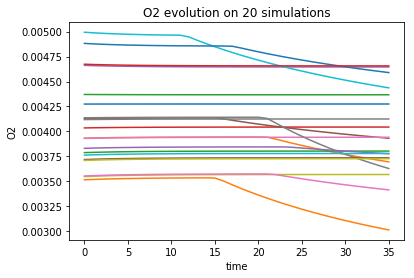

In [5]:
var = ['V' + str(i) for i in range(1, 21)]
plot_data(df[var])

## Set the parameters:
* **len_X**: the len_x last values of X are taken into account to compute descriptors
* **tau**: We want to predict if an accident happens at t + tau

The following variables are used to determine the event: "accident" that we want to predict:
* **thres_mean**: If |mean(X(0), ..., (t-1)) - X(t)| < thres_mean, then there is an accident at t.
* **X0_base, thres_gal**: If |X(t) - X0| < thres_gal then there is an accident.

In [7]:
params = {'len_X': 10,
          'tau': 5,
          'thres_mean': 5e-5,
          'X0_base': 0.0042,
          'thres_gal': 0.001}

variables = [col for col in list(df.columns) if 'V' in col]

### Processing X data and compute the accident variable Y

In [8]:
def process_var(df, variables):
    
    # Concatenation des x
    X = []
    trajec = []
    X_cummean = []

    for j in range(len(variables)):
        col = variables[j]
        X += list(df[col])
        # Trajec = the number of the trajectory
        trajec += [j for _ in range(len(df))]

        # CumMean of X (t-1 previous values)
        cummean = np.cumsum(df[col]) / np.array(range(1, len(df)+1))
        X_cummean += [df[col][0]] + list(cummean[:-1])

    data = pd.DataFrame({'X': X, 'trajec': trajec, 'X_cummean': X_cummean})
    
    # Compute Y
    data['X_diff'] = abs(data['X'] - data['X_cummean'])
    # The difference between X and the cummean is it below the threshold thres_mean ?
    data['Y1'] = data['X_diff'].apply(lambda x: 1 if x > params['thres_mean'] else 0)
    # The value of X is it below the general threshold thres_gal ?
    data['Y2'] = data['X'].apply(lambda x: 1 if abs(x - params['X0_base']) > params['thres_gal'] else 0)

    # The incident happens if one of the two previous event happen
    data['Y'] = data['Y1'] + data['Y2']
    data['Y'] = data['Y'].apply(lambda x: 1 if x > 0 else 0)
    
    return data[['Y', 'X', 'trajec']]

In [9]:
data = process_var(df, variables)

In [10]:
data.head(T + 1)

,Y,X,trajec
0,0,0.004274,0
1,0,0.004275,0
2,0,0.004275,0
3,0,0.004275,0
4,0,0.004275,0
5,0,0.004275,0
6,0,0.004275,0
7,0,0.004275,0
8,0,0.004275,0
9,0,0.004275,0


**trajec** is the number of the trajectory. When the number change, the value correspond to a new person.

## Compute descriptors on X data

In [96]:
# Separate data x in windows of lenght len_X
# and compute descriptors on this window

descriptors = {'X': [], 'Y': [], 'trajec': [],
               'mean': [],
               'diff_to_mean': [],
               'diff_first_second_mean': [],
               'diff_to_X0': []}
for i in range(1, params['len_X'] + 1):
    descriptors['X_{}'.format(i)] = []

nb_trajec = len(np.unique(data['trajec']))

for n in range(nb_trajec):
    for j in range(params['len_X'], T - params['tau']):
        i = n*T + j
        X_ = list(data['X'][i - params['len_X']:i])  # Past
        
        descriptors['X'].append(data['X'][i])
        descriptors['Y'].append(data['Y'][i])
        descriptors['trajec'].append(data['trajec'][i])

        descriptors['mean'].append(np.mean(X_))
        descriptors['diff_to_mean'].append(np.abs(data['X'][i] - np.mean(X_)))
        descriptors['diff_first_second_mean'].append(np.abs(np.mean(X_[:int(params['len_X']/2)])\
                                                            - np.mean(X_[int(params['len_X']/2):])))
        descriptors['diff_to_X0'].append(np.abs(np.mean(X_) - params['X0_base']))
        
        # Past values
        for k in range(1, params['len_X'] + 1):
            descriptors['X_{}'.format(k)].append((data['X'][i - k]))

descriptors = pd.DataFrame(descriptors)

name_descriptors = list(descriptors.columns)
name_descriptors.remove('X')
name_descriptors.remove('Y')
name_descriptors.remove('trajec')
print("The descriptors computed are:", name_descriptors)
print("{} trajectories of length {}".format(nb_trajec, T))

The descriptors computed are: ['X_1', 'X_10', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'diff_first_second_mean', 'diff_to_X0', 'diff_to_mean', 'mean']
100 trajectories of length 36


### Correlation coefficients

In [103]:
print("Correlation coefficients between the variables:")
descriptors[['X', 'Y', 'diff_first_second_mean', 'diff_to_X0', 'diff_to_mean', 'mean']].corr()

Correlation coefficients between the variables:


,X,Y,diff_first_second_mean,diff_to_X0,diff_to_mean,mean
X,1.000000,-0.123911,-0.126922,0.215260,-0.121901,0.994385
Y,-0.123911,1.000000,0.818809,0.040472,0.885895,-0.030151
diff_first_second_mean,-0.126922,0.818809,1.000000,0.043260,0.951211,-0.026664
diff_to_X0,0.215260,0.040472,0.043260,1.000000,0.029083,0.219114
diff_to_mean,-0.121901,0.885895,0.951211,0.029083,1.000000,-0.016296
mean,0.994385,-0.030151,-0.026664,0.219114,-0.016296,1.000000


**Remarques:**
La variable à prédire Y est fortement corrélées avec les deux variables decrivant la différence à la moyenne passée ('diff_to_mean', 'diff_first_second_mean'). Ces deux variables sont aussi corrélées, il vaut mieux choisir l'une des deux.

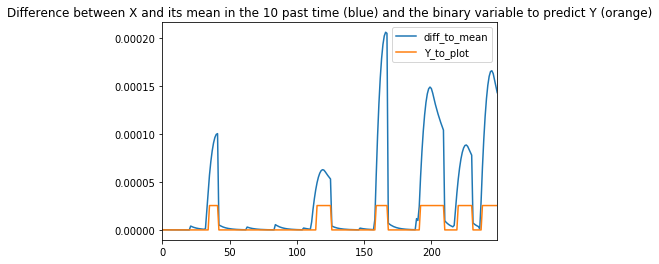

In [104]:
descriptors['Y_to_plot'] = descriptors['Y'] * descriptors['diff_to_mean'].mean()

descriptors[['diff_to_mean', 'Y_to_plot']][:250].plot()
plt.title('Difference between X and its mean in the {} past time (blue) and \
the binary variable to predict Y (orange)'.format(params['len_X']))
plt.show()

La corrélation est assez marquante entre la variable "différence avec la moyenne passée" et l'apparition d'un accident.

### Equilibrer les classes 

Il est important d'équilibrer les classes, i.e. avoir autant de données avec Y=1 et Y=0 pour entrainer un classifieur.

In [105]:
print(np.unique(descriptors['Y']))
len_Y1 = np.sum(descriptors['Y'])
len_Y0 = -np.sum([x - 1 for x in descriptors['Y']])
print("In the original database:")
print("Y=1:", len_Y1, "data")
print("Y=0:", len_Y0, "data")

[0 1]
In the original database:
Y=1: 453 data
Y=0: 1647 data


In [106]:
X1 = descriptors[descriptors['Y'] == 1]
X0 = descriptors[descriptors['Y'] == 0]
indices = np.random.permutation(range(len(X0)))

if len_Y1 < len_Y0:
    new_X0 = X0.iloc[indices[:len_Y1]]
    new_X1 = X1
else:
    new_X0 = X0
    new_X1 = X1.iloc[indices[:len_Y0]]
    
new_X = pd.concat((new_X0, new_X1))

print("In the new database:")
print("Y=1:", np.sum(new_X['Y']), "data")
print("Y=0:", -np.sum([x - 1 for x in new_X['Y']]), "data")

In the new database:
Y=1: 453 data
Y=0: 453 data


In [107]:
new_X.head()

,X,X_1,X_10,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,Y,diff_first_second_mean,diff_to_X0,diff_to_mean,mean,trajec,Y_to_plot
1624,0.004906,0.004906,0.004913,0.004906,0.004907,0.004907,0.004908,0.004909,0.004909,0.004910,0.004912,0,0.000004,0.000709,0.000003,0.004909,77,0.0
479,0.003715,0.003717,0.003724,0.003720,0.003722,0.003724,0.003724,0.003724,0.003724,0.003724,0.003724,0,0.000002,0.000477,0.000008,0.003723,22,0.0
1621,0.004907,0.004907,0.004919,0.004908,0.004909,0.004909,0.004910,0.004912,0.004913,0.004915,0.004917,0,0.000006,0.000712,0.000005,0.004912,77,0.0
560,0.004498,0.004499,0.004501,0.004499,0.004499,0.004500,0.004500,0.004500,0.004501,0.004501,0.004501,0,0.000002,0.000300,0.000002,0.004500,26,0.0
2025,0.004794,0.004795,0.004798,0.004795,0.004795,0.004795,0.004796,0.004796,0.004796,0.004797,0.004798,0,0.000002,0.000596,0.000002,0.004796,96,0.0


# Classification

#### Choose descriptors

In [156]:
print("Available descriptors:", name_descriptors)

Available descriptors: ['X_1', 'X_10', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'diff_first_second_mean', 'diff_to_X0', 'diff_to_mean', 'mean']


In [157]:
# Choose a list of descriptors:
list_descriptors = ['diff_to_X0', 'diff_to_mean', 'X']

#### Separate data in test and train set

In [158]:
X_data = np.array(new_X[list_descriptors + ['X']])
Y_data = np.array(new_X['Y'])

# Separate train / test
pct_test = 0.1
nb_test = int(pct_test * len(X_data))
print("{} data in the train set and {} in the test set".format(nb_test, len(X_data) - nb_test))
indices = np.random.permutation(range(len(X_data)))

X_test = X_data[indices[:nb_test]]
Y_test = Y_data[indices[:nb_test]]

X_train = X_data[indices[nb_test:]]
Y_train = Y_data[indices[nb_test:]]

90 data in the train set and 816 in the test set


#### Test several classifieur

In [159]:
def test_classif_model(model, X_train, Y_train, X_test, Y_test):
    
    model.fit(X_train, Y_train)

    score_train = model.score(X_train, Y_train)
    print("Score on train set: {}%".format(round(score_train*100, 3)))
    score_test = model.score(X_test, Y_test)
    print("Score on test set: {}%".format(round(score_test*100, 3)))

In [160]:
# Classification using a SVM (Support Vector Machine)
print("-- Linear SVM --")
lin_clf = svm.SVC()
test_classif_model(lin_clf, X_train, Y_train, X_test, Y_test)

print("-- Logistic Regression --")
logreg = LogisticRegression()
test_classif_model(logreg, X_train, Y_train, X_test, Y_test)

-- Linear SVM --
Score on train set: 50.368%
Score on test set: 46.667%
-- Logistic Regression --
Score on train set: 50.368%
Score on test set: 46.667%


** Résultats** (sur les données de test)
* Juste **diff_to_mean**: 46%
* 10 données passées: 49%
* **diff_first_second_mean**: 42-44%

In [162]:
# Coefficients de la regression logistique...
logreg.coef_

array([[ 0.00627067,  0.02056137, -0.02574612, -0.02574612]])